# Diamond Price Prediction


__Assignment:__

Engineer at least one feature and build a model that will predict price for each record, given an input file with the same layout as diamonds.txt minus price. 

The model does not have to use any fancy machine learning. 

Your feature engineering and model-building may be done in any programming language, although we prefer either Python or R. 

Please comment the code and make it easily readable.

__DATA description__

- Data: Tab delimited text file with header and 40,000 records of “round” diamonds 

- Price: in US dollars

- Cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

- Color: diamond color, from J (worst) to D (best)

- Clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

- Depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y)

- Table: width of top of diamond relative to widest point

- X: length in mm 

- Y: width in mm 

- Z: depth in mm 


### Data upload

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
# The file is a .txt file with tabs as separators
diamonds = pd.read_csv('diamonds.txt', sep = '\t')
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
price      40000 non-null int64
cut        40000 non-null object
color      40000 non-null object
clarity    40000 non-null object
depth      40000 non-null float64
table      40000 non-null float64
x          40000 non-null float64
y          40000 non-null float64
z          40000 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 2.7+ MB


In [3]:
# Checking the top and bottom sides of the dataframe for empty rows
print('Top columns')
display(diamonds.head())
print('\nLast columns')
display(diamonds.tail())

Top columns


,price,cut,color,clarity,depth,table,x,y,z
0,326,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,326,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,327,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,334,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,335,Good,J,SI2,63.3,58.0,4.34,4.35,2.75



Last columns


,price,cut,color,clarity,depth,table,x,y,z
39995,2757,Very Good,E,VS2,61.2,59.0,5.69,5.72,3.49
39996,2757,Premium,D,SI1,62.7,59.0,5.69,5.73,3.58
39997,2757,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56
39998,2757,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74
39999,2757,Ideal,D,SI2,62.2,55.0,5.83,5.87,3.64


### Data Cleaning

Based on the descriptors printed above, data appears clean. 

There are no null cells and the types of each column are in agreement with the descriptions of the data

### Feature selection

- __Non-numeric features__

In [4]:
# Functions used to isolate the non-numeric functions and print frequency of unique values
def column_checker (df):
    ''' 
    Function to check the values and frequencies of object columns
    '''
    # df1 dataframe whit the columns
    df_2 =  df.dtypes[(df.dtypes == 'object')]
    for col in range(0,len(df_2)):
        col = df_2.index[col]
        values = df[col].unique()
        print(col, '\n')
        print(df[col].value_counts().to_frame().merge((df[col].value_counts(normalize=True) * 100).to_frame().round(2).rename(columns= {col:col+'_Frequency'}), 
                                                           left_index = True, right_index = True, how = 'outer'), '\n')

In [5]:
column_checker(diamonds)

cut 

             cut  cut_Frequency
Ideal      15940          39.85
Premium    10284          25.71
Very Good   8933          22.33
Good        3624           9.06
Fair        1219           3.05 

color 

   color  color_Frequency
G   8427            21.07
E   7300            18.25
F   7084            17.71
H   6113            15.28
D   4968            12.42
I   4008            10.02
J   2100             5.25 

clarity 

      clarity  clarity_Frequency
SI1      9641              24.10
VS2      9135              22.84
SI2      6822              17.06
VS1      6003              15.01
VVS2     3776               9.44
VVS1     2720               6.80
IF       1352               3.38
I1        551               1.38 



The three categorical feature appear to be well distributed in the data with the exception of few categories on each feature (eg. I1 in clarity). Given that this is not a classification exercise, that should not be a problem for the model

__Converting the categorical variables__

For this I will used pd.dummies to generate the OneShot transformation

In [6]:
diamonds_1 = pd.get_dummies(diamonds)
diamonds_1.head()

,price,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,326,61.5,55.0,3.95,3.98,2.43,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,326,59.8,61.0,3.89,3.84,2.31,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,327,56.9,65.0,4.05,4.07,2.31,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,334,62.4,58.0,4.20,4.23,2.63,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,335,63.3,58.0,4.34,4.35,2.75,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


- __Numeric Features

In [7]:
# Obtaining descriptor for the numeric columns
diamonds.describe()

,price,depth,table,x,y,z
count,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000
mean,3927.016125,61.753705,57.46084,5.729185,5.731744,3.538131
std,3982.226472,1.430005,2.23462,1.121125,1.120159,0.709047
min,326.000000,43.000000,43.00000,0.000000,0.000000,0.000000
25%,949.000000,61.000000,56.00000,4.710000,4.720000,2.910000
50%,2401.000000,61.800000,57.00000,5.700000,5.710000,3.520000
75%,5313.250000,62.500000,59.00000,6.540000,6.540000,4.032500
max,18823.000000,79.000000,95.00000,10.140000,31.800000,31.800000


In [8]:
num_col_list = diamonds.dtypes[(diamonds.dtypes == 'float')].index

All numeric features appear to have relatively small variation (e.g. low Standard Deviation) I will try them in the model with out normalization/standarization for now. 

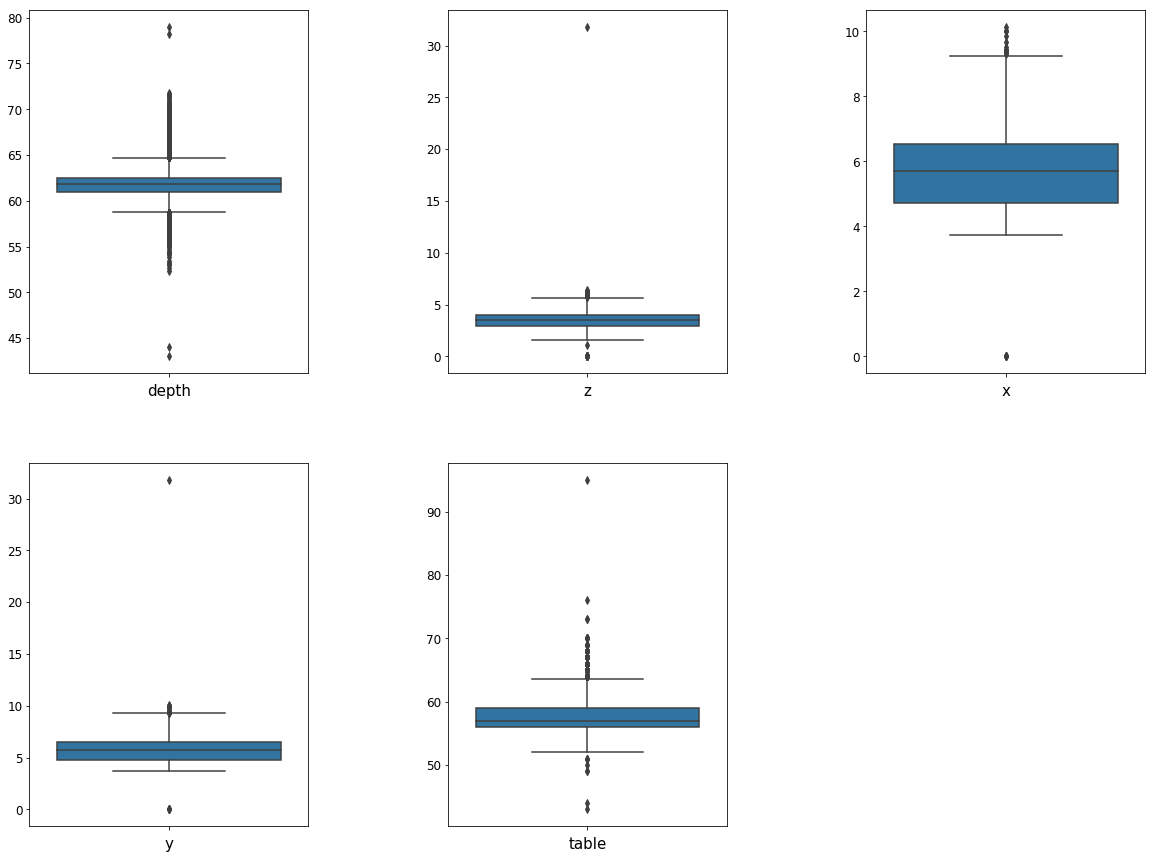

In [9]:
row1 = 2
col1 = 3

fig, axs = pl.subplots(row1, col1, figsize=(20,15))
fig.subplots_adjust(wspace=0.5, hspace=0.25)
axs[1, 2].axis('off')

for num, name in enumerate(num_col_list):
    i = num % row1
    j = num % col1
    graph = sns.boxplot(y = diamonds[name], ax = axs[i,j], linewidth = 1.5)
    graph.set_xlabel(name, fontsize = 15)
    graph.set_ylabel('', fontsize = 1)
    graph.tick_params(labelsize = 12)


y, z and table appear to have outliers. I will remove them with the IQR method

In [10]:
def outliers(df, types_of_columns):
    '''
    This function iterates over the types_of columns list and returns a list of indexes where outliers are detected
    '''
    outliers_all = np.array([], dtype='int64')
    for column in types_of_columns:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        step = (Q3 - Q1)*2
        out_list_feat=list(df[~((df[column] >= Q1 - step) & (df[column] <= Q3 + step))].index)
        outliers_all = np.append(outliers_all, out_list_feat)
    return outliers_all

In [11]:
dia_outliers = outliers(diamonds, num_col_list)
diamonds_no_outliers = diamonds[diamonds.index.isin(dia_outliers)==False]

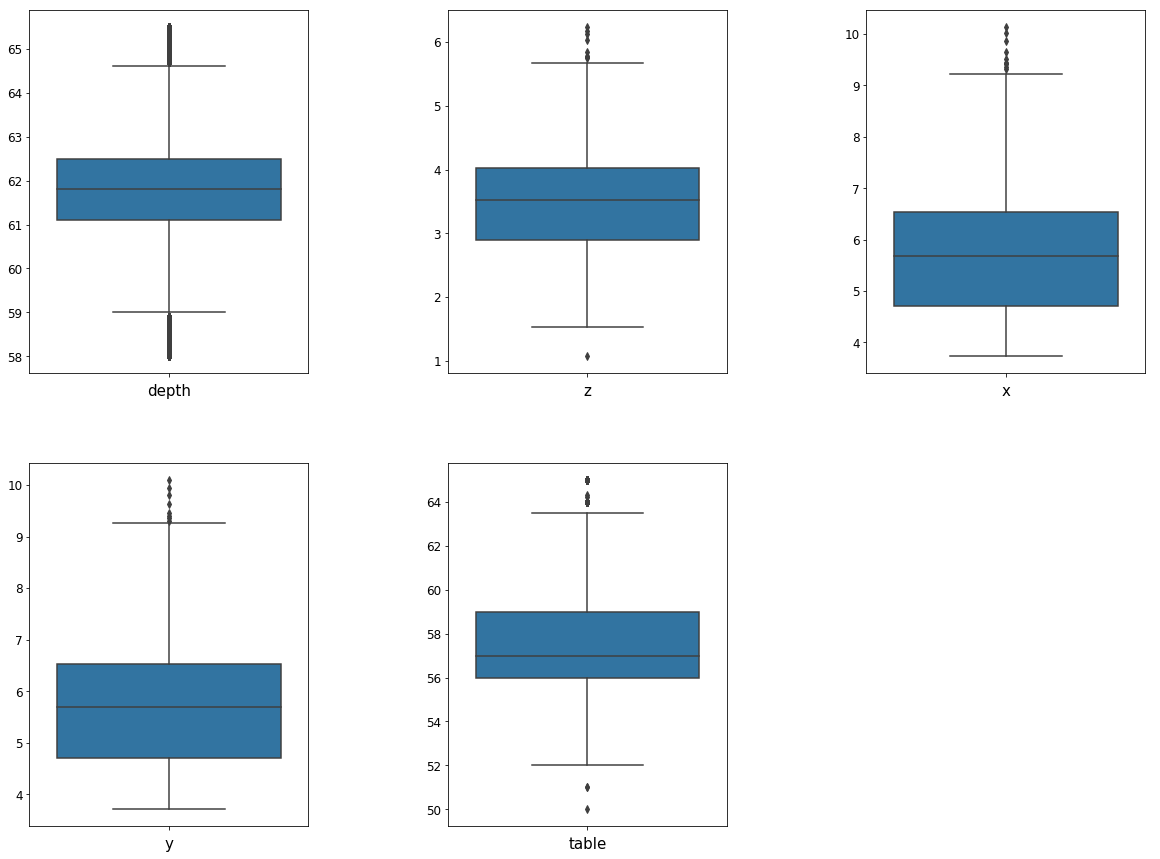

In [12]:
row1 = 2
col1 = 3

fig, axs = pl.subplots(row1, col1, figsize=(20,15))
fig.subplots_adjust(wspace=0.5, hspace=0.25)
axs[1, 2].axis('off')

for num, name in enumerate(num_col_list):
    i = num % row1
    j = num % col1
    graph = sns.boxplot(y = diamonds_no_outliers[name], ax = axs[i,j], linewidth = 1.5)
    graph.set_xlabel(name, fontsize = 15)
    graph.set_ylabel('', fontsize = 1)
    graph.tick_params(labelsize = 12)

### Checking for correlations between numeric features

In [13]:
cor_df = pd.DataFrame()
for i in range(0,len(num_col_list)):
    cor_df = pd.concat([cor_df, diamonds_no_outliers[num_col_list[i]]],axis=1)  
cor_df.head()

,depth,table,x,y,z
0,61.5,55.0,3.95,3.98,2.43
1,59.8,61.0,3.89,3.84,2.31
3,62.4,58.0,4.20,4.23,2.63
4,63.3,58.0,4.34,4.35,2.75
5,62.8,57.0,3.94,3.96,2.48


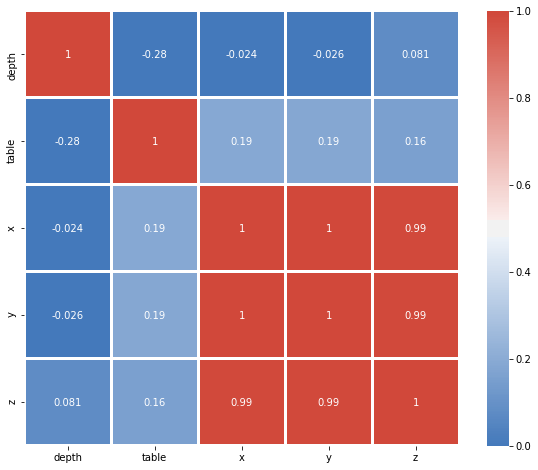

In [14]:
f, ax = pl.subplots(figsize=(10, 8))
corr = cor_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 15, as_cmap=True),
            square=True, ax=ax, annot=True, vmin=0, vmax=1, linewidths=2, xticklabels=1, yticklabels=True)


It appears that X, Y and Z are highly correlated. Y and Z will be removed and X will be used in the model. 

In [15]:
data_ready = diamonds_no_outliers.drop(['cut','color', 'clarity', 'y', 'z'], 1).merge(diamonds_1.drop(['price', 'depth', 'table', 'x', 'y', 'z'], 1), left_index = True, right_index = True, how = 'left')
data_ready.shape

(39040, 24)

# Price Prediction Model

In [16]:
target = data_ready[['price']]
features = data_ready.drop(['price'], 1)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.40, random_state = 10)

In [18]:
# LINEAR REGRESSION
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

diam_reg = linear_model.LinearRegression() # Creating alinear regression model 
diam_reg.fit(X_train,Y_train) # Fiting the model with the training datasets
y_pred = diam_reg.predict(X_test) # Predicting Prices
performance = diam_reg.score(X_test, Y_test) # Determine performance of the model with R-square
# CROSSVALIDATION
cross_valid = cross_val_score(diam_reg, features, target, cv = 10)
cross_valid_mean = np.mean(cross_valid)

print("Rsquare: {:0.2f}\nCrosvalidation results {}\nMean R-square of the crossvalidation {}".format(performance, cross_valid, cross_valid_mean))

Rsquare: 0.85
Crosvalidation results [ -2.14908179  -0.81153342   0.11698982   0.84347167   0.07800207
   0.80366149 -53.98752294 -12.26331653  -7.23288747  -5.3935022 ]
Mean R-square of the crossvalidation -7.99957192956393
